In [1]:
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import datasets, layers, models, backend
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import IPython.display as display

In [2]:
AUTOTUNE=tf.data.experimental.AUTOTUNE

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [4]:
import pathlib
# data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos', untar=True)


In [5]:
train_images = pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_train\\')

train_images_list = list(train_images.glob('*.png'))
train_images = []
for image in train_images_list:
    train_images.append(str(image))

In [6]:
val_images =   pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_validate\\')

val_images_list = list(val_images.glob('*.png'))
val_images = []
for image in val_images_list:
    val_images.append(str(image))

In [7]:
len(val_images)

1120

In [8]:
test_images =  pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_test\\')

test_images_list = list(test_images.glob('*.png'))
test_images = []
for image in test_images_list:
    test_images.append(str(image))

In [9]:
train_labels = pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_train\\')

train_labels_list = list(train_labels.glob('*.png'))
train_labels = []
for label in train_labels_list:
    train_labels.append(str(label))


In [10]:
val_labels =   pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_validate\\')

val_labels_list = list(val_labels.glob('*.png'))
val_labels = []
for label in val_labels_list:
    val_labels.append(str(label))

In [11]:
len(val_labels)

1120

In [12]:
test_labels =  pathlib.Path('H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_test\\')

test_labels_list = list(test_labels.glob('*.png'))
test_labels = []
for label in test_labels_list:
    test_labels.append(str(label))

In [13]:
# test_labels

In [14]:
#  now need to group them together

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [16]:
def get_a_palette(img):
    list0 = get_arr_list(img)
    palette = get_palette(list0)
    return palette

In [17]:
# img.shape = (256,256,4)
def get_arr_list(img):
    list0= []
    for i in range(256):
        for j in range(256):
            list0.append(img[i,j,:].tolist())
    return list0

def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item


def sort_and_deduplicate(l):
    return list(uniq(sorted(l, reverse=True)))

def get_palette(lst):
    palette = sort_and_deduplicate(lst)
    return palette

In [18]:
def decode_img(img):
    img = tf.image.decode_png(img, channels=4) #color images
#     img / 255.0
    img = tf.image.convert_image_dtype(img, tf.float32)
    #convert unit8 tensor to floats in the [0,1]range
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 
    #resize the image into 32*32 

In [19]:
file_path1 = train_labels[0]

In [20]:
file_path1

'H:\\Documents\\COMP3710\\keras_png_slices_data\\keras_png_slices_data\\keras_png_slices_seg_train\\seg_057_slice_2.nii.png'

In [21]:
img = tf.io.read_file(file_path1)
decoded_image = decode_img(img)
decoded_image.numpy().shape

(256, 256, 4)

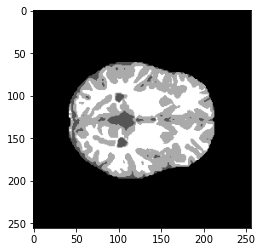

In [22]:
plt.imshow(decoded_image.numpy())

In [23]:
palette = get_a_palette(decoded_image.numpy())
palette

[[1.0, 1.0, 1.0, 1.0],
 [0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 1.0],
 [0.3333333432674408, 0.3333333432674408, 0.3333333432674408, 1.0],
 [0.0, 0.0, 0.0, 1.0]]

In [24]:
def ohm(palette, img):
    one_hot_map = []
    for colour in palette:
        class_map = tf.reduce_all(tf.equal(img, colour), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    return one_hot_map

In [25]:
# for image, label in train_ds:
#     print(label)

In [26]:
#  both paths are to an image
def map_fn(image_path, label_path):
    # Load the raw data from the file as a string.
    img = tf.io.read_file(image_path)
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_png(img, channels=4) # channels=3 for RGB, channels=1 for grayscale
    # Resize the image to the desired size.
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 
    # Standardise values to be in the [0, 1] range.
    img = tf.cast(img, tf.float32) / 255.0
    # One-hot encode the label.
    label1 = tf.io.read_file(label_path)
    label2 = decode_img(label1)
    one_hot = ohm(palette, label2)
    # Return the processed image and label.
    return img, one_hot

# Use Dataset.map to apply this transformation.
train_ds = train_ds.map(map_fn)
val_ds = val_ds.map(map_fn)
test_ds = test_ds.map(map_fn)

In [27]:
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy().shape)

Image shape: (256, 256, 4)


Label: AxesImage(54,36;334.8x217.44)


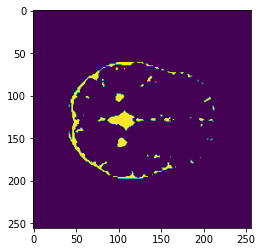

In [28]:
for image, label in train_ds.take(1):
    print('Label:', plt.imshow(label[:,:,2]))

In [29]:
label_test = tf.io.read_file(train_labels[1])
# label_test

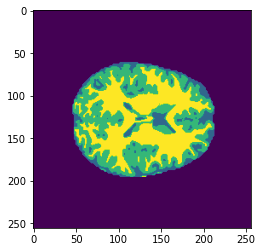

In [30]:
img = decode_img(label_test)
plt.imshow(img.numpy()[:,:,2])

In [31]:
ohm_test = ohm(palette, img)

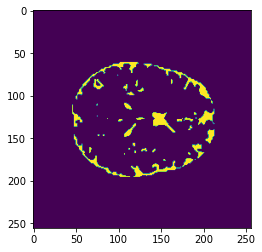

In [32]:
plt.imshow(ohm_test[:,:,2])

In [33]:
inputs = tf.keras.Input(shape=(256, 256, 4), name="img")
x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)

copy_1 = x
block_1_output = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)

copy_2 = x
block_2_output = tf.keras.layers.MaxPooling2D(2)(x)
# block_2_output = layers.add([x, block_1_output])

x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(block_2_output)
x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)

copy_3 = x
block_3_output = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(block_3_output)
x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)

copy_4 = x
block_4_output = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same")(block_4_output)
x = tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same")(x)

block_5_output = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2,2))(x)
# block_5_output = keras.layers.Conv2DTranspose(512, 1)(x)

concat_4_5 = tf.keras.layers.concatenate([copy_4, block_5_output])

x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(concat_4_5)
x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)

block_4_output = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2,2))(x)
concat_3_4 = tf.keras.layers.concatenate([copy_3, block_4_output])

x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(concat_3_4)
x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)

block_3_output = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2))(x)
concat_2_3 = tf.keras.layers.concatenate([copy_2, block_3_output])

x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(concat_2_3)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)

block_5_output = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2,2))(x)
concat_1_2 = tf.keras.layers.concatenate([copy_1, block_5_output])

x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(concat_1_2)
x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)

outputs = tf.keras.layers.Conv2D(4, 1, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1184        img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_________________________________________________________________________________________

In [34]:
type(np.array(train_ds))

numpy.ndarray

In [35]:
# for image in train_ds:
#     print(image)

In [36]:
# for label in train_ds:
#     print(label)

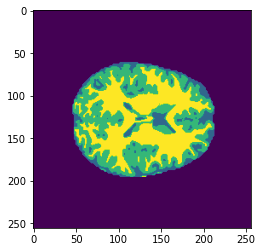

In [37]:
# for image, label in train_ds.take(1):
#     print('Image shape:', image.numpy().shape)
img_test = decode_img(label_test)
plt.imshow(img_test.numpy()[:,:,2])

In [38]:
# img_test.numpy()

In [39]:
def dice_coef(y_true, y_pred, smooth=0):
    y_true_f = tf.keras.backend.batch_flatten(y_true)
    y_pred_f = tf.keras.backend.batch_flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    sums = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)

    return (2. * intersection + smooth) / (sums + smooth)

def dice_coef_loss(y_true, y_pred):
#     return 1-dice_coef(y_true, y_pred)
#     img = tf.cast(img, tf.float32) / 255.0
    loss = 1-dice_coef(y_true, y_pred)
    output = tf.cast(loss, tf.float32)
    return output


In [40]:
# def dice_coef(y_true, y_pred, smooth=1):
#     print("y-true = " + str(y_true))
#     print("y-pred = " + str(y_pred))


#     return -1


In [41]:
# def dice_coef(y_true, y_pred):
#     y_true_f = tf.keras.layers.Flatten()(y_true)
#     y_pred_f = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
#     return (2. * intersection) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f))

# def dice_coef_loss(y_true, y_pred):
#     return 1-dice_coef(y_true, y_pred)

In [42]:
# loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[dice_coef])


In [43]:
# Compile the model.
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

# Train the model.
history = model.fit(train_ds.batch(32), # using a batch size of 32
                    validation_data=val_ds.batch(32),
                    epochs=1)

Train for 302 steps, validate for 35 steps
302/302 [==============================] - 271s 898ms/step - loss: 0.3488 - dice_coef: 0.8022 - val_loss: 0.2525 - val_dice_coef: 0.8515


In [44]:
image_test, label_test = next(iter(test_ds.batch(9)))
prediction = model.predict(image_test)

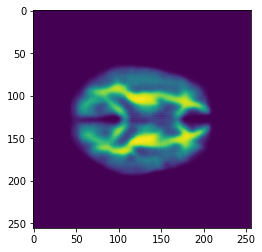

In [45]:
plt.imshow(tf.argmax(prediction[0][:,:, 0]))

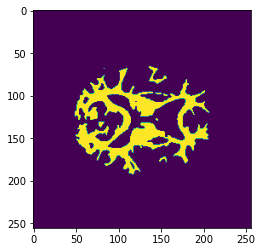

In [46]:
plt.imshow(tf.argmax(label_test[0][:,:,0]))

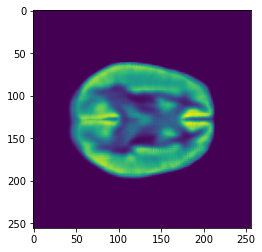

In [47]:
plt.imshow(tf.argmax(prediction[0][:,:,1]))

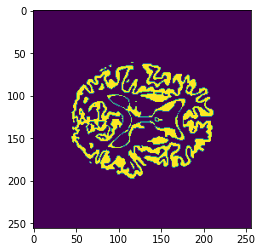

In [48]:
plt.imshow(tf.argmax(label_test[0][:,:,1]))

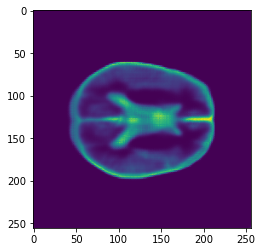

In [49]:
plt.imshow(tf.argmax(prediction[0][:,:,2]))

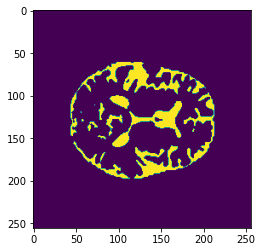

In [50]:
plt.imshow(tf.argmax(label_test[0][:,:,2]))

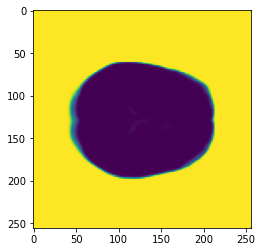

In [51]:
plt.imshow(tf.argmax(prediction[0][:,:,3]))

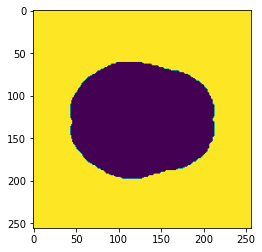

In [52]:
tf.argmax(plt.imshow(label_test[0][:,:,3]))

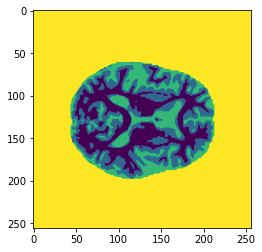

In [53]:
plt.imshow(tf.argmax(label_test[0],axis=-1))

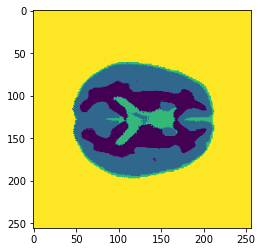

In [54]:
plt.imshow(tf.argmax(prediction[0],axis=-1))